<a href="https://colab.research.google.com/github/arnabbiswas66/multimodal-fake-news-classifier/blob/main/Twitter_multimodal_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install -q -U "tensorflow-text==2.11.*"
!pip install -q tensorflow_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 63.0 MB/s eta 0:00:00


In [2]:
#!pip install -q tf-models-official==2.11.0

In [3]:
from tensorflow.python.platform.tf_logging import warn
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import re
from os import listdir
import shutil
import glob
import random
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow_text as text
#from official.nlp import optimization  # to create AdamW optimizer
tf.get_logger().setLevel('ERROR')
import warnings

warnings.filterwarnings('ignore')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
BASE_SAVE_LOCATION = "/content/drive/MyDrive/multimodal-news"

In [4]:
def get_df(file):
    return pd.read_table(file,sep = '\t', lineterminator='\n')

In [5]:
train_df = get_df('/content/drive/MyDrive/multimodal-news/mediaeval2015/devset/tweets.txt')
test_df = get_df('/content/drive/MyDrive/multimodal-news/mediaeval2015/testset/tweets.txt')

In [6]:

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14277 entries, 0 to 14276
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweetId     14277 non-null  int64 
 1   tweetText   14277 non-null  object
 2   userId      14277 non-null  int64 
 3   imageId(s)  14277 non-null  object
 4   username    14277 non-null  object
 5   timestamp   14277 non-null  object
 6   label       14277 non-null  object
dtypes: int64(2), object(5)
memory usage: 780.9+ KB


In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweetId     3755 non-null   int64 
 1   tweetText   3755 non-null   object
 2   userId      3755 non-null   int64 
 3   imageId(s)  3755 non-null   object
 4   username    3755 non-null   object
 5   timestamp   3755 non-null   object
 6   label       3755 non-null   object
dtypes: int64(2), object(5)
memory usage: 205.5+ KB


## Flatten the image folder structure for both devset and testset for ease of processing

In [ ]:
def flatten(directory, targetDir):
    if not os.path.exists(targetDir):
        os.makedirs(targetDir)
    for dirpath, _, filenames in os.walk(directory, topdown=False):
        for filename in filenames:
            i = 0
            source = os.path.join(dirpath, filename)
            target = os.path.join(targetDir, filename)

            shutil.move(source, target)

    print("Moved", directory, "to", targetDir)

In [ ]:
# Devset
SRC_DIR = '/content/drive/MyDrive/multimodal-news/mediaeval2015/devset/Medieval2015_DevSet_Images/'
TARGET_DIR = '/content/drive/MyDrive/multimodal-news/mediaeval2015/devset/images/'

flatten(SRC_DIR, TARGET_DIR)

Moved /content/drive/MyDrive/multimodal-news/mediaeval2015/devset/Medieval2015_DevSet_Images/ to /content/drive/MyDrive/multimodal-news/mediaeval2015/devset/images/


In [ ]:
# Testset
SRC_DIR = '/content/drive/MyDrive/multimodal-news/mediaeval2015/testset/TestSetImages/'
TARGET_DIR = '/content/drive/MyDrive/multimodal-news/mediaeval2015/testset/images/'

flatten(SRC_DIR, TARGET_DIR)

Moved /content/drive/MyDrive/multimodal-news/mediaeval2015/testset/TestSetImages/ to /content/drive/MyDrive/multimodal-news/mediaeval2015/testset/images/


## Initial Preprocessing of data

In [8]:
# TODO consider both the images and not just the first one
def return_first_image(row):
    return row['imageId(s)'].split(',')[0].strip()

In [9]:
train_df['first_image_id'] = train_df.apply (lambda row: return_first_image(row),axis=1)
test_df['first_image_id'] = test_df.apply (lambda row: return_first_image(row),axis=1)

In [10]:
images_train_dataset = [i for i in train_df['first_image_id'].tolist()]
images_train_folder = [i.split('.')[0].strip() for i in listdir('/content/drive/MyDrive/multimodal-news/mediaeval2015/devset/images/')]
images_train_not_available = set(images_train_dataset)-set(images_train_folder)
images_train_not_available

{'boston_fake_35', 'sandyB_real_4', 'sandyB_real_6', 'sochi_fake_1fake'}

In [11]:
images_test_dataset = [i.split(',')[0].strip() for i in test_df['first_image_id'].tolist()]
images_test_folder = [i.split('.')[0].strip() for i in listdir('/content/drive/MyDrive/multimodal-news/mediaeval2015/testset/images/')]
images_test_not_available = set(images_test_dataset)-set(images_test_folder)
images_test_not_available

{'eclipse_video_01', 'syrianboy_1', 'varoufakis_1'}

In [12]:
print(train_df.shape, test_df.shape)

(14277, 8) (3755, 8)


In [13]:
train_df = train_df[~train_df['first_image_id'].isin(images_train_not_available)]

In [14]:
test_df = test_df[~test_df['first_image_id'].isin(images_test_not_available)]
print(train_df.shape, test_df.shape)

(14258, 8) (1923, 8)


In [15]:
train_text = train_df['tweetText'].tolist()
test_text = test_df['tweetText'].tolist()

train_images = [i for i in train_df['first_image_id'].tolist()]
test_images = [i.split(',')[0].strip() for i in test_df['first_image_id'].tolist()]

trainY = train_df['label'].tolist()
trainY = [1 if i=='real' else 0 for i in trainY]

testY = test_df['label'].tolist()
testY = [1 if i=='real' else 0 for i in testY]

In [16]:
len(train_text),len(train_images),len(trainY),len(test_text),len(test_images),len(testY)

(14258, 14258, 14258, 1923, 1923, 1923)

In [17]:
# calculate the maximum document length
def max_length(lines):
    return max([len(s.split()) for s in lines])

maximum length: 901


(array([   0.,    4.,  327.,  532.,  755.,  760.,  843.,  791.,  904.,
        2534., 2379.,  775., 1462., 1113., 1047.,   17.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 12., 15., 16.,
        18., 20., 25., 30.]),
 <BarContainer object of 16 artists>)

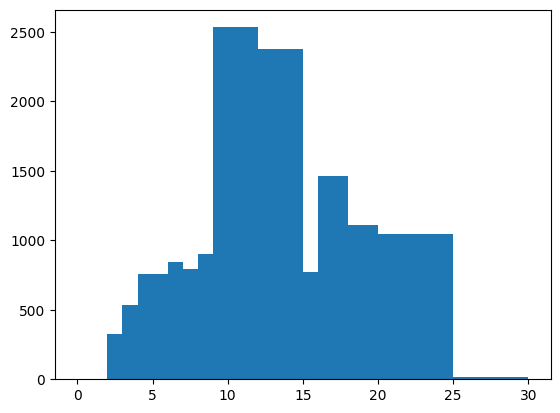

In [18]:
print("maximum length:", max_length(train_text))
plt.hist([len(s.split()) for s in train_text],bins=[0,1,2,3,4,5,6,7,8,9,12,15,16,18,20,25,30])

In [19]:
l=[len(s.split()) for s in train_text]
count=0.0
for i in l:
    if i>25:
        count+=1
print(count,len(l))
print(count/len(l))

17.0 14258
0.0011923130873895357


In [20]:
max_seq_length=25

# Visualize random tweets

In [21]:
DEV_IMAGE_DIR = '/content/drive/MyDrive/multimodal-news/mediaeval2015/devset/images/'
TEST_IMAGE_DIR = '/content/drive/MyDrive/multimodal-news/mediaeval2015/testset/images/'

In [22]:
def find_image_from_name_in_dir(image_name, dir):
  for name in glob.glob(dir+'/'+image_name+'.*'):
    return name

In [23]:
def visualise(index, text_df, image_df, train=True):
  path = DEV_IMAGE_DIR if train else TEST_IMAGE_DIR
  text = text_df[index]
  image_path = find_image_from_name_in_dir(image_df[index],path)
  image = plt.imread(image_path)
  plt.subplot(1, 1, 1)
  plt.title(text)
  plt.imshow(image)


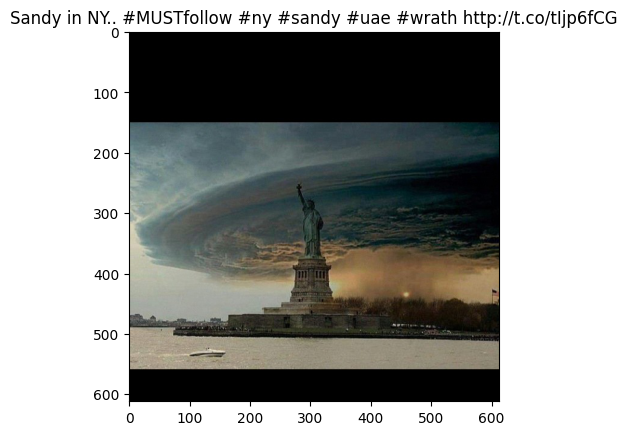

In [24]:
indx = random.randint(0, 3000)
visualise(indx, train_text, train_images)

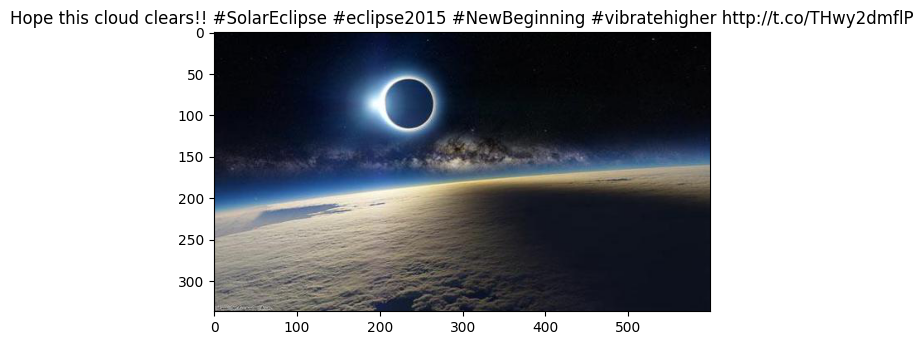

In [25]:
indx = random.randint(0, 1000)
visualise(indx, test_text, test_images, False)

## Start of modeling

In [26]:
# Alternate dataframes for modeling
train_df_model = train_df[['tweetText', 'first_image_id', 'label']]
train_df_model['label'] = train_df_model['label'].apply(lambda x: 1 if x=='real' else 0)
train_df_model['image_1'] = train_df_model['first_image_id'].apply(lambda x: find_image_from_name_in_dir(x, DEV_IMAGE_DIR))
train_df_model = train_df_model.drop(['first_image_id'], axis=1)
train_df_model.head(5)

,tweetText,label,image_1
0,¿Se acuerdan de la película: “El día después d...,0,/content/drive/MyDrive/multimodal-news/mediaev...
1,@milenagimon: Miren a Sandy en NY! Tremenda i...,0,/content/drive/MyDrive/multimodal-news/mediaev...
2,"Buena la foto del Huracán Sandy, me recuerda a...",0,/content/drive/MyDrive/multimodal-news/mediaev...
3,Scary shit #hurricane #NY http://t.co/e4JLBUfH,0,/content/drive/MyDrive/multimodal-news/mediaev...
4,My fave place in the world #nyc #hurricane #sa...,0,/content/drive/MyDrive/multimodal-news/mediaev...


In [27]:
# Check to make sure all the first_image_id are tied with a path
train_df_model[train_df_model['image_1'].isnull()]

,tweetText,label,image_1


In [28]:
train_df_model['label'].value_counts()

0    9353
1    4905
Name: label, dtype: int64

In [29]:
test_df_model = test_df[['tweetText', 'first_image_id', 'label']]
test_df_model['label'] = test_df_model['label'].apply(lambda x: 1 if x=='real' else 0)
test_df_model['image_1'] = test_df_model['first_image_id'].apply(lambda x: find_image_from_name_in_dir(x, TEST_IMAGE_DIR))
test_df_model = test_df_model.drop(['first_image_id'], axis=1)
test_df_model.head(10)

,tweetText,label,image_1
0,kereeen RT @Shyman33: Eclipse from ISS.... htt...,0,/content/drive/MyDrive/multimodal-news/mediaev...
1,Absolutely beautiful! RT @Shyman33: Eclipse fr...,0,/content/drive/MyDrive/multimodal-news/mediaev...
2,“@Shyman33: Eclipse from ISS.... http://t.co/C...,0,/content/drive/MyDrive/multimodal-news/mediaev...
3,Eclipse from ISS.... http://t.co/En87OtvsU6,0,/content/drive/MyDrive/multimodal-news/mediaev...
4,@ebonfigli: Éclipse vue de l'ISS... Autre chos...,0,/content/drive/MyDrive/multimodal-news/mediaev...
5,“@ebonfigli: Éclipse vue de l'ISS... Autre cho...,0,/content/drive/MyDrive/multimodal-news/mediaev...
6,Éclipse vue de l'ISS... Autre chose... http://...,0,/content/drive/MyDrive/multimodal-news/mediaev...
7,@ebonfigli: Éclipse vue de l'ISS... Autre chos...,0,/content/drive/MyDrive/multimodal-news/mediaev...
8,Dit dus \0/ RT “@News_Executive: The Solar ecl...,0,/content/drive/MyDrive/multimodal-news/mediaev...
9,Photo: The Solar eclipse as seen from the Inte...,0,/content/drive/MyDrive/multimodal-news/mediaev...


In [30]:
# Check to make sure all the first_image_id are tied with a path
test_df_model[test_df_model['image_1'].isnull()]

,tweetText,label,image_1


In [31]:
test_df_model['label'].value_counts()

1    1207
0     716
Name: label, dtype: int64

### Handling imbalance of data in devset

In [32]:

#from sklearn.model_selection import train_test_split
#train_df_model, val_df_model = train_test_split(train_df_model, test_size=0.1, 
 #                                    stratify=train_df_model["label"].values, random_state=42)

### Save the dataframes for faster access

In [34]:
#Save training df
train_df_model.to_pickle(BASE_SAVE_LOCATION+"/train.pickle")
#Save Val df
#val_df_model.to_pickle(BASE_SAVE_LOCATION+"/val.pickle")
#Save testing df
test_df_model.to_pickle(BASE_SAVE_LOCATION+"/test.pickle")

## Load the dataframes

In [6]:
#Load training df
train_df_model = pd.read_pickle(BASE_SAVE_LOCATION+"/train.pickle")
#Load Val df
#val_df_model = pd.read_pickle(BASE_SAVE_LOCATION+"/val.pickle")
#Load testing df
test_df_model = pd.read_pickle(BASE_SAVE_LOCATION+"/test.pickle")
print(train_df_model.shape, test_df_model.shape)

(14258, 3) (1923, 3)


# Data input pipeline

In [7]:
# Define TF Hub paths to the BERT encoder and its preprocessor
bert_model_path = (
    "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1"
)
bert_preprocess_path = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

In [8]:
def make_bert_preprocessing_model(sentence_features, seq_length=128):
    """Returns Model mapping string features to BERT inputs.

  Args:
    sentence_features: A list with the names of string-valued features.
    seq_length: An integer that defines the sequence length of BERT inputs.

  Returns:
    A Keras Model that can be called on a list or dict of string Tensors
    (with the order or names, resp., given by sentence_features) and
    returns a dict of tensors for input to BERT.
  """

    input_segments = [
        tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)
        for ft in sentence_features
    ]

    # Tokenize the text to word pieces.
    bert_preprocess = hub.load(bert_preprocess_path)
    tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name="tokenizer")
    segments = [tokenizer(s) for s in input_segments]

    # Optional: Trim segments in a smart way to fit seq_length.
    # Simple cases (like this example) can skip this step and let
    # the next step apply a default truncation to approximately equal lengths.
    truncated_segments = segments

    # Pack inputs. The details (start/end token ids, dict of output tensors)
    # are model-dependent, so this gets loaded from the SavedModel.
    packer = hub.KerasLayer(
        bert_preprocess.bert_pack_inputs,
        arguments=dict(seq_length=seq_length),
        name="packer",
    )
    model_inputs = packer(truncated_segments)
    return keras.Model(input_segments, model_inputs)


In [9]:
bert_preprocess_model = make_bert_preprocessing_model(["text_1"])
bert_preprocess_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_1 (InputLayer)         [(None,)]                 0         
                                                                 
 tokenizer (KerasLayer)      (None, None, None)        0         
                                                                 
 packer (KerasLayer)         {'input_mask': (None, 12  0         
                             8),                                 
                              'input_word_ids': (None            
                             , 128),                             
                              'input_type_ids': (None            
                             , 128)}                             
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [10]:
idx = np.random.choice(len(train_df_model))
row = train_df_model.iloc[idx]
sample_text_1, sample_text_2 = row["tweetText"], row["tweetText"]
print(f"Text 1: {sample_text_1}")
print(f"Text 2: {sample_text_2}")

test_text = [np.array([sample_text_1])]
text_preprocessed = bert_preprocess_model(test_text)

print("Keys           : ", list(text_preprocessed.keys()))
print("Shape Word Ids : ", text_preprocessed["input_word_ids"].shape)
print("Word Ids       : ", text_preprocessed["input_word_ids"][0, :16])
print("Shape Mask     : ", text_preprocessed["input_mask"].shape)
print("Input Mask     : ", text_preprocessed["input_mask"][0, :16])
print("Shape Type Ids : ", text_preprocessed["input_type_ids"].shape)
print("Type Ids       : ", text_preprocessed["input_type_ids"][0, :16])


Text 1: #newyork #hurricane #sandy http://t.co/8wcCP9c5
Text 2: #newyork #hurricane #sandy http://t.co/8wcCP9c5
Keys           :  ['input_mask', 'input_word_ids', 'input_type_ids']
Shape Word Ids :  (1, 128)
Word Ids       :  tf.Tensor(
[ 101 1001 2047 7677 8024 1001 7064 1001 7525 8299 1024 1013 1013 1056
 1012 2522], shape=(16,), dtype=int32)
Shape Mask     :  (1, 128)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1], shape=(16,), dtype=int32)
Shape Type Ids :  (1, 128)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(16,), dtype=int32)


In [11]:
def dataframe_to_dataset(dataframe):
    columns = ['tweetText', 'image_1', 'label']
    dataframe = dataframe[columns].copy()
    labels = dataframe.pop("label")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

## Preprocessing utilities

In [12]:
resize = (224, 224)
bert_input_features = ["input_word_ids", "input_type_ids", "input_mask"]

In [13]:
def preprocess_image(image_path):
  extension = tf.strings.split(image_path,'.')[-1]
  image = tf.io.read_file(image_path)
  if extension == b"gif":
    image = tf.io.decode_image(image, 3, expand_animations=False)
  elif extension == b"png":
    image = tf.image.decode_png(image, 3)
  else:
    image = tf.image.decode_jpeg(image, 3)
  image = tf.image.resize(image, resize)
  return image

In [14]:
def preprocess_text(text_1):
  text_1 = tf.convert_to_tensor([text_1])
  output = bert_preprocess_model([text_1])
  output = {feature: tf.squeeze(output[feature]) for feature in bert_input_features}
  return output

In [15]:
def preprocess_text_and_image(sample):
  image_1 = preprocess_image(sample["image_1"])
  text = preprocess_text(sample["tweetText"])
  return {"image_1": image_1, "text": text}

In [16]:
batch_size = 32
auto = tf.data.AUTOTUNE

In [17]:
def prepare_dataset(dataframe, training=True):
  ds = dataframe_to_dataset(dataframe)
  if training:
      ds = ds.shuffle(len(train_df_model))
  ds = ds.map(lambda x, y: (preprocess_text_and_image(x), y)).cache()
  ds = ds.batch(batch_size).prefetch(auto)
  return ds

In [18]:
train_ds = prepare_dataset(train_df_model)
#validation_ds = prepare_dataset(val_df_model, False)
test_ds = prepare_dataset(test_df_model, False)

## Model Building

### Projection

In [19]:
def project_embeddings(
    embeddings, num_projection_layers, projection_dims, dropout_rate
):
    projected_embeddings = keras.layers.Dense(units=projection_dims)(embeddings)
    for _ in range(num_projection_layers):
        x = tf.nn.gelu(projected_embeddings)
        x = keras.layers.Dense(projection_dims)(x)
        x = keras.layers.Dropout(dropout_rate)(x)
        x = keras.layers.Add()([projected_embeddings, x])
        projected_embeddings = keras.layers.LayerNormalization()(x)
    return projected_embeddings


### Vision encoder

In [20]:
def create_vision_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the pre-trained ResNet50V2 model to be used as the base encoder.
    resnet_v2 = keras.applications.EfficientNetB0(
        include_top=False, weights="imagenet", pooling="avg"
    )
    # Set the trainability of the base encoder.
    for layer in resnet_v2.layers:
        layer.trainable = trainable

    # Receive the images as inputs.
    image_1 = keras.Input(shape=(224, 224, 3), name="image_1")
    
    # Preprocess the input image.
    preprocessed_1 = keras.applications.resnet_v2.preprocess_input(image_1)
    
    # Generate the embeddings for the images using the resnet_v2 model
    # concatenate them.
    embeddings = resnet_v2(preprocessed_1)
    #embeddings = keras.layers.Concatenate()([embeddings_1, embeddings_2])

    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the vision encoder model.
    return keras.Model([image_1], outputs, name="vision_encoder")

### Text Encoder

In [21]:
def create_text_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the pre-trained BERT model to be used as the base encoder.
    bert = hub.KerasLayer(bert_model_path, name="bert",)
    # Set the trainability of the base encoder.
    bert.trainable = trainable

    # Receive the text as inputs.
    bert_input_features = ["input_type_ids", "input_mask", "input_word_ids"]
    inputs = {
        feature: keras.Input(shape=(128,), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }

    # Generate embeddings for the preprocessed text using the BERT model.
    embeddings = bert(inputs)["pooled_output"]

    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the text encoder model.
    return keras.Model(inputs, outputs, name="text_encoder")

## MultiModal model

In [22]:
def create_multimodal_model(
    num_projection_layers=0,
    projection_dims=128,
    dropout_rate=0.1,
    vision_trainable=False,
    text_trainable=False,
    attention=False
):
    # Receive the images as inputs.
    image_1 = keras.Input(shape=(128, 128, 3), name="image_1")
    
    # Receive the text as inputs.
    bert_input_features = ["input_type_ids", "input_mask", "input_word_ids"]
    text_inputs = {
        feature: keras.Input(shape=(128,), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }

    # Create the encoders.
    vision_encoder = create_vision_encoder(
        num_projection_layers, projection_dims, dropout_rate, vision_trainable
    )
    text_encoder = create_text_encoder(
        num_projection_layers, projection_dims, dropout_rate, text_trainable
    )

    # Fetch the embedding projections.
    vision_projections = vision_encoder([image_1])
    vision_projections = keras.layers.Dropout(dropout_rate)(vision_projections)
    text_projections = text_encoder(text_inputs)
    text_projections = keras.layers.Dropout(dropout_rate)(text_projections)

    # Cross-attention.
    if attention:
        query_value_attention_seq = keras.layers.Attention(use_scale=True, dropout=0.2)(
            [vision_projections, text_projections]
        )


    # Concatenate the projections and pass through the classification layer.
    concatenated = keras.layers.Concatenate()([vision_projections, text_projections])
    if attention:
        concatenated = keras.layers.Concatenate()([concatenated, query_value_attention_seq])
    outputs = keras.layers.Dense(1, activation="sigmoid")(concatenated)
    return keras.Model([image_1, text_inputs], outputs)

## Multimodal Model without attention

In [23]:
multimodal_model = create_multimodal_model(attention=False)
multimodal_model.summary()

16705208/16705208 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_mask (InputLayer)        [(None, 128)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 input_word_ids (InputLayer

### Model Training

In [24]:
epochs = 15

In [25]:
checkpoint_filepath = '/content/drive/MyDrive/multimodal-news/model-checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [26]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics= [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

In [64]:
multimodal_model.compile(
    optimizer=tf.keras.optimizers.Adam(), loss=loss, metrics=metrics
)

history = multimodal_model.fit(train_ds, validation_data=test_ds, epochs=epochs, batch_size=batch_size)

Epoch 1/15
446/446 [==============================] - 47s 86ms/step - loss: 0.5562 - accuracy: 0.7237 - precision: 0.6399 - recall: 0.4499 - val_loss: 1.0413 - val_accuracy: 0.3812 - val_precision: 0.6889 - val_recall: 0.0257
Epoch 2/15
446/446 [==============================] - 37s 82ms/step - loss: 0.4941 - accuracy: 0.7660 - precision: 0.7068 - recall: 0.5464 - val_loss: 0.8154 - val_accuracy: 0.5398 - val_precision: 0.9086 - val_recall: 0.2966
Epoch 3/15
446/446 [==============================] - 37s 83ms/step - loss: 0.4742 - accuracy: 0.7819 - precision: 0.7277 - recall: 0.5847 - val_loss: 0.6968 - val_accuracy: 0.6271 - val_precision: 0.9224 - val_recall: 0.4432
Epoch 4/15
446/446 [==============================] - 37s 83ms/step - loss: 0.4668 - accuracy: 0.7871 - precision: 0.7375 - recall: 0.5916 - val_loss: 0.5868 - val_accuracy: 0.7743 - val_precision: 0.9328 - val_recall: 0.6901
Epoch 5/15
446/446 [==============================] - 37s 83ms/step - loss: 0.4560 - accuracy: 0

In [57]:
#multimodal_model.load_weights(checkpoint_filepath)

In [65]:
_,accuracy, precision, recall = multimodal_model.evaluate(test_ds)
print(f"Accuracy on the test set: {round(accuracy * 100, 2)}%.")

61/61 [==============================] - 4s 70ms/step - loss: 0.4741 - accuracy: 0.8008 - precision: 0.9221 - recall: 0.7457
Accuracy on the test set: 80.08%.


## Multimodal model with cross-attention

In [66]:
multimodal_model = create_multimodal_model(attention=True)
multimodal_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_mask (InputLayer)        [(None, 128)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 input_word_ids (InputLayer)    [(None, 128)]        0           []                         

### Model training

In [67]:
multimodal_model.compile(
    optimizer=tf.keras.optimizers.Adam(), loss=loss, metrics=metrics
)

history = multimodal_model.fit(train_ds, validation_data=test_ds, epochs=epochs, batch_size=batch_size)

Epoch 1/15
446/446 [==============================] - 48s 87ms/step - loss: 0.5834 - accuracy: 0.7145 - precision: 0.6718 - recall: 0.4776 - val_loss: 0.8541 - val_accuracy: 0.4041 - val_precision: 0.6276 - val_recall: 0.1243
Epoch 2/15
446/446 [==============================] - 37s 83ms/step - loss: 0.5245 - accuracy: 0.7484 - precision: 0.6742 - recall: 0.5197 - val_loss: 0.8308 - val_accuracy: 0.4181 - val_precision: 0.7245 - val_recall: 0.1176
Epoch 3/15
446/446 [==============================] - 37s 83ms/step - loss: 0.4910 - accuracy: 0.7683 - precision: 0.7091 - recall: 0.5537 - val_loss: 0.7447 - val_accuracy: 0.5601 - val_precision: 0.8932 - val_recall: 0.3397
Epoch 4/15
446/446 [==============================] - 37s 83ms/step - loss: 0.4839 - accuracy: 0.7756 - precision: 0.7193 - recall: 0.5704 - val_loss: 0.6004 - val_accuracy: 0.7603 - val_precision: 0.9239 - val_recall: 0.6736
Epoch 5/15
446/446 [==============================] - 37s 82ms/step - loss: 0.4649 - accuracy: 0

In [68]:
_,accuracy, precision, recall = multimodal_model.evaluate(test_ds)
print(f"Accuracy on the test set: {round(accuracy * 100, 2)}%.")

61/61 [==============================] - 4s 71ms/step - loss: 0.4448 - accuracy: 0.8024 - precision: 0.8832 - recall: 0.7896
Accuracy on the test set: 80.24%.


So, we got decent accuracy, pecision and recall with the Attention mechanism. We would like to experiment with increased complexity of the model to see if we get better numbers.

# Experiment 1 - num_projection_layer = 1

In [69]:
multimodal_model = create_multimodal_model(num_projection_layers = 1, attention=True)
multimodal_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_mask (InputLayer)        [(None, 128)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 input_word_ids (InputLayer)    [(None, 128)]        0           []                         

In [70]:
multimodal_model.compile(
    optimizer=tf.keras.optimizers.Adam(), loss=loss, metrics=metrics
)

history = multimodal_model.fit(train_ds, validation_data=test_ds, epochs=epochs, batch_size=batch_size)

Epoch 1/15
446/446 [==============================] - 51s 90ms/step - loss: 0.6260 - accuracy: 0.6862 - precision: 0.6225 - recall: 0.4298 - val_loss: 1.1391 - val_accuracy: 0.3671 - val_precision: 0.4107 - val_recall: 0.0191
Epoch 2/15
446/446 [==============================] - 38s 85ms/step - loss: 0.5387 - accuracy: 0.7336 - precision: 0.6534 - recall: 0.4801 - val_loss: 0.6669 - val_accuracy: 0.6069 - val_precision: 0.8263 - val_recall: 0.4731
Epoch 3/15
446/446 [==============================] - 38s 85ms/step - loss: 0.4891 - accuracy: 0.7682 - precision: 0.7092 - recall: 0.5529 - val_loss: 0.5848 - val_accuracy: 0.7551 - val_precision: 0.9035 - val_recall: 0.6827
Epoch 4/15
446/446 [==============================] - 37s 84ms/step - loss: 0.4717 - accuracy: 0.7810 - precision: 0.7272 - recall: 0.5817 - val_loss: 0.5072 - val_accuracy: 0.7889 - val_precision: 0.8796 - val_recall: 0.7688
Epoch 5/15
446/446 [==============================] - 38s 84ms/step - loss: 0.4457 - accuracy: 0

# Experiment 2 - num_projection_layers = 2

In [71]:
multimodal_model = create_multimodal_model(num_projection_layers = 2, attention=True)
multimodal_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_mask (InputLayer)        [(None, 128)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 input_word_ids (InputLayer)    [(None, 128)]        0           []                         

In [72]:
multimodal_model.compile(
    optimizer=tf.keras.optimizers.Adam(), loss=loss, metrics=metrics
)

history = multimodal_model.fit(train_ds, validation_data=test_ds, epochs=epochs, batch_size=batch_size)

Epoch 1/15
446/446 [==============================] - 54s 91ms/step - loss: 0.6347 - accuracy: 0.6780 - precision: 0.6059 - recall: 0.4216 - val_loss: 0.8072 - val_accuracy: 0.4831 - val_precision: 0.7825 - val_recall: 0.2444
Epoch 2/15
446/446 [==============================] - 38s 86ms/step - loss: 0.5223 - accuracy: 0.7443 - precision: 0.6682 - recall: 0.5099 - val_loss: 0.5913 - val_accuracy: 0.7670 - val_precision: 0.9193 - val_recall: 0.6893
Epoch 3/15
446/446 [==============================] - 38s 86ms/step - loss: 0.4785 - accuracy: 0.7761 - precision: 0.7186 - recall: 0.5737 - val_loss: 0.5520 - val_accuracy: 0.7868 - val_precision: 0.9087 - val_recall: 0.7341
Epoch 4/15
446/446 [==============================] - 38s 86ms/step - loss: 0.4504 - accuracy: 0.7965 - precision: 0.7517 - recall: 0.6098 - val_loss: 0.4880 - val_accuracy: 0.8029 - val_precision: 0.9140 - val_recall: 0.7572
Epoch 5/15
446/446 [==============================] - 38s 85ms/step - loss: 0.4332 - accuracy: 0

It doesn't seem that increasing the projection layer to 2 is giving any significant benefits. We will stick to 1 layer.

# Experiment 3 - EfficientV2 as vision encoder

In [28]:
def create_vision_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the pre-trained ResNet50V2 model to be used as the base encoder.
    resnet_v2 = keras.applications.EfficientNetV2B0(
        include_top=False, weights="imagenet", pooling="avg"
    )
    # Set the trainability of the base encoder.
    for layer in resnet_v2.layers:
        layer.trainable = trainable

    # Receive the images as inputs.
    image_1 = keras.Input(shape=(224, 224, 3), name="image_1")
    
    # Preprocess the input image.
    preprocessed_1 = keras.applications.resnet_v2.preprocess_input(image_1)
    
    # Generate the embeddings for the images using the resnet_v2 model
    # concatenate them.
    embeddings = resnet_v2(preprocessed_1)
    #embeddings = keras.layers.Concatenate()([embeddings_1, embeddings_2])

    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the vision encoder model.
    return keras.Model([image_1], outputs, name="vision_encoder")

In [35]:
multimodal_model = create_multimodal_model(num_projection_layers = 1, attention=True)
multimodal_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_mask (InputLayer)        [(None, 128)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 input_word_ids (InputLayer)    [(None, 128)]        0           []                         

In [36]:
multimodal_model.compile(
    optimizer=tf.keras.optimizers.Adam(), loss=loss, metrics=metrics
)

history = multimodal_model.fit(train_ds, validation_data=test_ds, epochs=epochs, batch_size=batch_size)

Epoch 1/15
446/446 [==============================] - 163s 338ms/step - loss: 0.5844 - accuracy: 0.6941 - precision: 0.5810 - recall: 0.3839 - val_loss: 0.5492 - val_accuracy: 0.7899 - val_precision: 0.8388 - val_recall: 0.8235
Epoch 2/15
446/446 [==============================] - 32s 72ms/step - loss: 0.4879 - accuracy: 0.7732 - precision: 0.7188 - recall: 0.5596 - val_loss: 0.4671 - val_accuracy: 0.7962 - val_precision: 0.8462 - val_recall: 0.8252
Epoch 3/15
446/446 [==============================] - 32s 72ms/step - loss: 0.4491 - accuracy: 0.7964 - precision: 0.7464 - recall: 0.6181 - val_loss: 0.4509 - val_accuracy: 0.7998 - val_precision: 0.8750 - val_recall: 0.7945
Epoch 4/15
446/446 [==============================] - 32s 71ms/step - loss: 0.4307 - accuracy: 0.8065 - precision: 0.7601 - recall: 0.6393 - val_loss: 0.4290 - val_accuracy: 0.8014 - val_precision: 0.8852 - val_recall: 0.7854
Epoch 5/15
446/446 [==============================] - 32s 72ms/step - loss: 0.4072 - accuracy:

# Experiment 4 - EfficientNetV2B3, num_projection_layers = 0 (to keep the complexity low)

---



In [32]:
def create_vision_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the pre-trained ResNet50V2 model to be used as the base encoder.
    resnet_v2 = keras.applications.EfficientNetV2B3(
        include_top=False, weights="imagenet", pooling="avg"
    )
    # Set the trainability of the base encoder.
    for layer in resnet_v2.layers:
        layer.trainable = trainable

    # Receive the images as inputs.
    image_1 = keras.Input(shape=(224, 224, 3), name="image_1")
    
    # Preprocess the input image.
    preprocessed_1 = keras.applications.resnet_v2.preprocess_input(image_1)
    
    # Generate the embeddings for the images using the resnet_v2 model
    # concatenate them.
    embeddings = resnet_v2(preprocessed_1)
    #embeddings = keras.layers.Concatenate()([embeddings_1, embeddings_2])

    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the vision encoder model.
    return keras.Model([image_1], outputs, name="vision_encoder")

In [43]:
multimodal_model = create_multimodal_model(num_projection_layers = 0, attention=True)
multimodal_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_mask (InputLayer)        [(None, 128)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 input_word_ids (InputLayer)    [(None, 128)]        0           []                         

In [44]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.00001)

In [45]:
multimodal_model.compile(
    optimizer=tf.keras.optimizers.Adam(), loss=loss, metrics=metrics
)

history = multimodal_model.fit(train_ds, validation_data=test_ds, epochs=10, batch_size=batch_size, callbacks=reduce_lr)

Epoch 1/10
446/446 [==============================] - 69s 123ms/step - loss: 0.4365 - accuracy: 0.8104 - precision: 0.7933 - recall: 0.6736 - val_loss: 0.4251 - val_accuracy: 0.8539 - val_precision: 0.8833 - val_recall: 0.8840 - lr: 0.0010
Epoch 2/10
446/446 [==============================] - 50s 113ms/step - loss: 0.3458 - accuracy: 0.8563 - precision: 0.8222 - recall: 0.7429 - val_loss: 0.3805 - val_accuracy: 0.8684 - val_precision: 0.8962 - val_recall: 0.8940 - lr: 0.0010
Epoch 3/10
446/446 [==============================] - 50s 113ms/step - loss: 0.3086 - accuracy: 0.8723 - precision: 0.8380 - recall: 0.7794 - val_loss: 0.3920 - val_accuracy: 0.8320 - val_precision: 0.8180 - val_recall: 0.9420 - lr: 0.0010
Epoch 4/10
446/446 [==============================] - 50s 113ms/step - loss: 0.3030 - accuracy: 0.8712 - precision: 0.8336 - recall: 0.7814 - val_loss: 0.3769 - val_accuracy: 0.8497 - val_precision: 0.8441 - val_recall: 0.9329 - lr: 0.0010
Epoch 5/10
446/446 [====================

In [48]:
multimodal_model = create_multimodal_model(num_projection_layers = 0, attention=True)
multimodal_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_mask (InputLayer)        [(None, 128)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 input_word_ids (InputLayer)    [(None, 128)]        0           []                         

In [49]:
multimodal_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0005), loss=loss, metrics=metrics
)

history = multimodal_model.fit(train_ds, validation_data=test_ds, epochs=10, batch_size=batch_size, callbacks=reduce_lr)

Epoch 1/10
446/446 [==============================] - 69s 120ms/step - loss: 0.4466 - accuracy: 0.8043 - precision: 0.8105 - recall: 0.6291 - val_loss: 0.3987 - val_accuracy: 0.8341 - val_precision: 0.8627 - val_recall: 0.8749 - lr: 5.0000e-04
Epoch 2/10
446/446 [==============================] - 50s 113ms/step - loss: 0.3496 - accuracy: 0.8543 - precision: 0.8243 - recall: 0.7325 - val_loss: 0.4059 - val_accuracy: 0.8128 - val_precision: 0.8130 - val_recall: 0.9114 - lr: 5.0000e-04
Epoch 3/10
446/446 [==============================] - 50s 112ms/step - loss: 0.3168 - accuracy: 0.8673 - precision: 0.8394 - recall: 0.7596 - val_loss: 0.4049 - val_accuracy: 0.8424 - val_precision: 0.8587 - val_recall: 0.8964 - lr: 5.0000e-04
Epoch 4/10
446/446 [==============================] - 50s 113ms/step - loss: 0.2921 - accuracy: 0.8833 - precision: 0.8576 - recall: 0.7923 - val_loss: 0.3945 - val_accuracy: 0.8544 - val_precision: 0.8879 - val_recall: 0.8790 - lr: 5.0000e-04
Epoch 5/10
446/446 [====

In [61]:
_,accuracy, precision, recall = multimodal_model.evaluate(test_ds)
print(f"Accuracy on the test set: {round(accuracy * 100, 2)}%.")

61/61 [==============================] - 6s 91ms/step - loss: 0.3809 - accuracy: 0.8461 - precision: 0.8507 - recall: 0.9155
Accuracy on the test set: 84.61%.


In [62]:
history.history

{'loss': [0.4466278851032257,
  0.34957563877105713,
  0.3168178200721741,
  0.29208219051361084,
  0.27505528926849365,
  0.2666989862918854,
  0.2458564192056656,
  0.23950769007205963,
  0.23834162950515747,
  0.23042337596416473],
 'accuracy': [0.8043383955955505,
  0.8542572855949402,
  0.8673025965690613,
  0.8832935690879822,
  0.8884836435317993,
  0.8908683061599731,
  0.9021601676940918,
  0.9037032127380371,
  0.9044045209884644,
  0.9084023237228394],
 'precision': [0.8104974627494812,
  0.8242716193199158,
  0.8393782377243042,
  0.8576472997665405,
  0.8635665774345398,
  0.8663312196731567,
  0.8821864128112793,
  0.8815903067588806,
  0.8851674795150757,
  0.8902624249458313],
 'recall': [0.6290903091430664,
  0.7325178384780884,
  0.7596330046653748,
  0.792252779006958,
  0.8026503324508667,
  0.8073394298553467,
  0.8258919715881348,
  0.8318042755126953,
  0.8297655582427979,
  0.8369011282920837],
 'val_loss': [0.3986546993255615,
  0.40588560700416565,
  0.4049191

In [65]:
y_test = np.concatenate([y for x, y in test_ds], axis=0)
y_test

array([1, 0, 1, ..., 0, 1, 1])

In [66]:
y_pred = multimodal_model.predict(test_ds)
y_pred = [1 if i>=0.5 else 0 for i in y_pred]

61/61 [==============================] - 6s 91ms/step


In [67]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score

In [68]:
print(f'Accuracy == {accuracy_score(y_test,y_pred)}')
print(f'F1 == {f1_score(y_test,y_pred,average=None)}')
print(f'Precision == {precision_score(y_test,y_pred,average=None)}')
print(f'Recall == {recall_score(y_test,y_pred,average=None)}')

Accuracy == 0.8460738429537181
F1 == [0.77910448 0.88188348]
Precision == [0.83653846 0.85065435]
Recall == [0.72905028 0.91549296]
